# ADS 599 Team 7 Final Project

## Image Classification For Pneumonia Detection using Chest X-Ray Images

#### University of San Diego - Applied Data Science
#### Chow, Eva
#### Duan, Dingyi 
#### Tan, Abby

#### Github Link: https://github.com/dingyiduan7/ADS599_Capstone_Image_Recognition

### Load the necessary packages

In [1]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from random import randint

from scipy import ndimage

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report,confusion_matrix

## Stage 1: Data Loading and Exploratory Data Analysis (EDA)

Display all our datasets/folders

In [2]:
print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray"))
print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray/train"))
print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray/val"))
print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray/test"))

['test', 'train', 'val']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


Here we have three folders of train, val and test sets.
Each folder contains two subfolders of "NORMAL" and "PNEUMONIA" images.

In [3]:
# set the path for all three datasets
data_dir = Path("D:/USD-ADS_graduate/ADS-599/chest_xray/")
train_dir = data_dir/"train"
val_dir = data_dir/"val"
test_dir = data_dir/"test"

In [4]:
# function to load the data into dataframes from each folder and label them

def load_data(data_path):
    normal_dir = data_path/"NORMAL"
    pneum_dir = data_path/"PNEUMONIA"
    
    # images are in .jpeg format
    normal_img = normal_dir.glob('*.jpeg')
    pneum_img = pneum_dir.glob('*.jpeg')
    
    img_data = []
    img_label = []
    
    for img in normal_img:
        img_data.append(img)
        img_label.append('NORMAL')
        
    for img in pneum_img:
        img_data.append(img)
        img_label.append('PNEUMONIA')
    df = pd.DataFrame(img_data,columns=['images'])
    df['label'] = img_label
    df = df.reset_index(drop=True)
    
    return df

In [5]:
df_train = load_data(train_dir)
print(df_train.sample(10))

                                                 images      label
4717  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA
921   D:\USD-ADS_graduate\ADS-599\chest_xray\train\N...     NORMAL
1398  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA
2274  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA
1840  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA
5101  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA
1284  D:\USD-ADS_graduate\ADS-599\chest_xray\train\N...     NORMAL
586   D:\USD-ADS_graduate\ADS-599\chest_xray\train\N...     NORMAL
4680  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA
4332  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA


Create all the dataframes seprately to avoid data leakage

In [6]:
df_val = load_data(val_dir)
df_test = load_data(test_dir)
print('The training data has a shape of:',df_train.shape)
print('The validate data has a shape of:',df_val.shape)
print('The test data has a shape of:',df_test.shape)

The training data has a shape of: (5216, 2)
The validate data has a shape of: (16, 2)
The test data has a shape of: (624, 2)


Let's check to see whether the training set is balanced.

<AxesSubplot:title={'center':'Training Data Label Distribution'}>

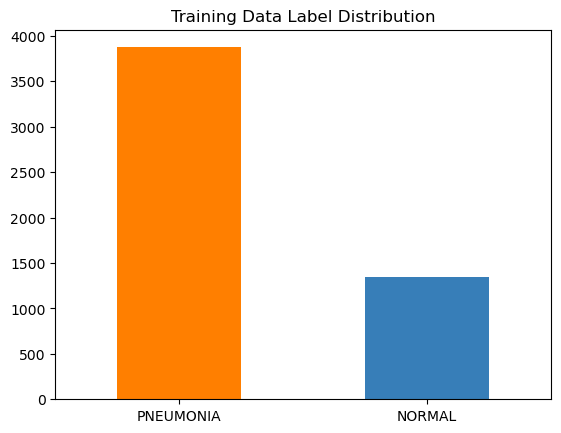

In [7]:
# using colorblind friendly colors
df_train['label'].value_counts().plot(kind='bar',rot=0,title="Training Data Label Distribution",color=['#ff7f00','#377eb8'])

As many real life problems, our training data is obviously imbalanced. We could perform oversampling to balance the dataset.

In [8]:
# Oversampling
df_train['images'][0]

WindowsPath('D:/USD-ADS_graduate/ADS-599/chest_xray/train/NORMAL/IM-0115-0001.jpeg')

We can also look at our images to see how different are normal and pneumonia on x-ray

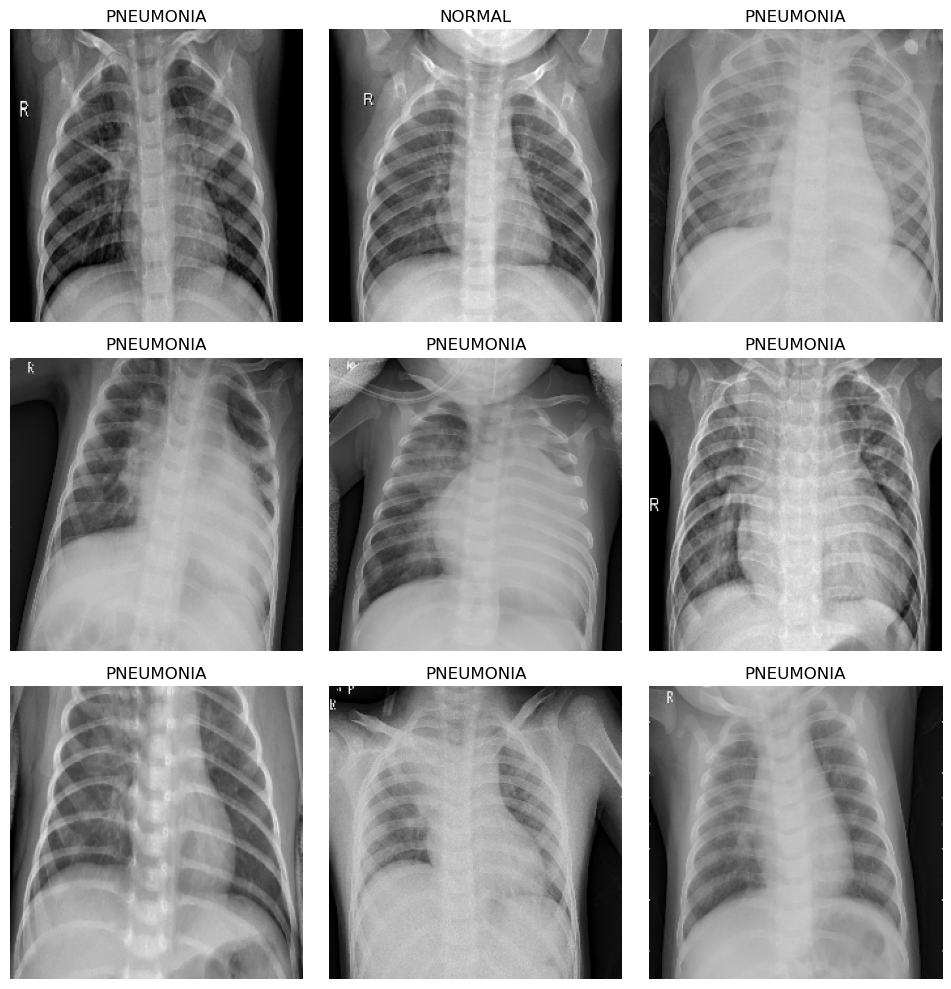

In [9]:
plt.figure(figsize=(10,10))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    j = randint(0, len(df_train))
    img_path = str(df_train['images'][j])
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224))
    plt.title(df_train['label'][j])
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()

From the raw images we can see that it can be hard for our bare eyes to tell the difference.

## Stage 2: Data Cleaning and Preprocessing

### Image Formatting/ Image Augmentation


Reference: https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/

Let's take a random sample from our training set and look at how different image formatting and augmentation will take effect on our images.

(-0.5, 223.5, 223.5, -0.5)

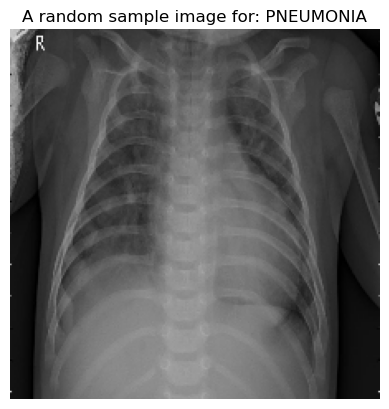

In [10]:
sample_ind = randint(0, len(df_train))
sample_path= str(df_train['images'][sample_ind])
sample_img = cv2.imread(sample_path)
sample_img = cv2.resize(sample_img,(224,224))
plt.title('A random sample image for: %s'%df_train['label'][sample_ind])
plt.imshow(sample_img)
plt.axis('off')

In [11]:
def original(img):
    return img

#### 1. Resizing 
Resize the image to a given length and width

In [12]:
def resizing(img):
    res_img = cv2.resize(img, (50,50)) # using 300 as an arbitrary dimension
    return res_img

#### 2. Gray Scaling
The image will be converted to gray scale (range of gray shades from white to black) the computer will assign each pixel a value based on how dark it is. All the numbers are put into an array and the computer does computations on that array.

In [13]:
def gray_scale(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img

#### 3. Reflection/Flip
flip images horizontally and vertically. Some frameworks do not provide function for vertical flips. But, a vertical flip is equivalent to rotating an image by 180 degrees and then performing a horizontal flip.

In [14]:
def ref_flip(img):
    flip_img = cv2.flip(img,1)
    return flip_img

#### 4. Gaussian Blurring
Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function. It is a widely used effect in graphics software, typically to reduce image noise.

In [15]:
def gau_blur(img):
    blur_img = ndimage.gaussian_filter(img, sigma= 5.11)
    return blur_img

#### 5. Histogram Equalization
Histogram equalization is another image processing technique to increase global contrast of an image using the image intensity histogram. This method needs no parameter, but it sometimes results in an unnatural looking image.

In [16]:
def hist_eq(img):
    img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
    hist_img= cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    return hist_img

#### 6. Rotation
Rotating an image might not preserve its original dimensions (depending on what angle you choose to rotate it with )

In [17]:
def rotation(img):
    rows,cols = img.shape[0],img.shape[1]
    randDeg = random.randint(-180, 180)
    matrix = cv2.getRotationMatrix2D((cols/2, rows/2), randDeg, 0.70)
    rot_img = cv2.warpAffine(img, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT)
    return rot_img 

#### 7. Channel Conversion
Some images are in  greyscale (1 channel), therefore convert them to 3 channel

In [18]:
def channel_con(img):
    if img.shape[2]==1:
        img = dstack([img,img,img])
    return img 

#### 8. Color Conversion
Images read using cv2 are in BGR format(by default), convert it to RGB.

In [19]:
def color_con(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

There we have it, a series of image augmentation and processing that enables us to modify the images for training to improve the model performance.
#### Augmentation Comparison

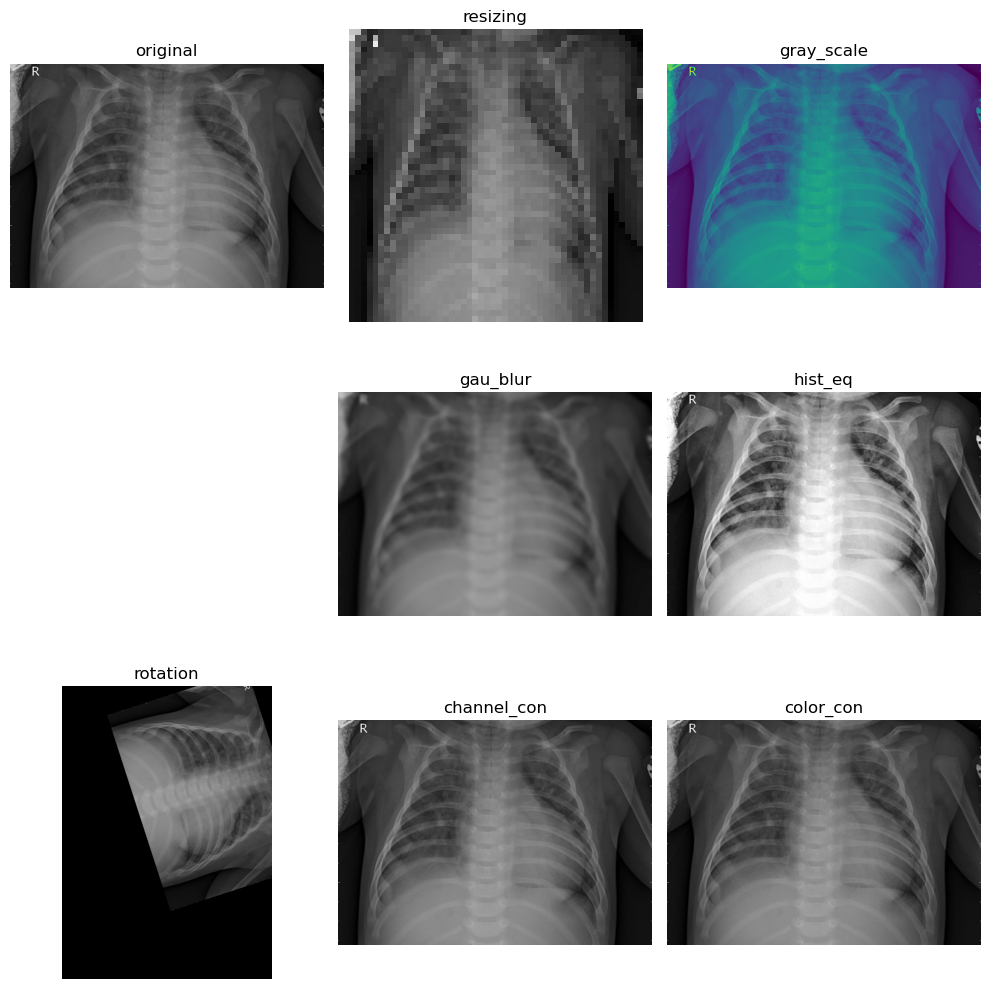

In [20]:
img_aug = [original, resizing, gray_scale, ref_flip, gau_blur, hist_eq, rotation, channel_con, color_con]

plt.figure(figsize=(10,10))
for aug in img_aug:
    ax = plt.subplot(3,3,img_aug.index(aug)+1)
    sample_img = cv2.imread(sample_path)
    sample_img = aug(sample_img)
    plt.title(aug.__name__)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.tight_layout()   

#### Image when all augmentation is performed.

error: OpenCV(4.6.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xe823dd8f::Set<3,-1,-1>,struct cv::impl::A0xe823dd8f::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


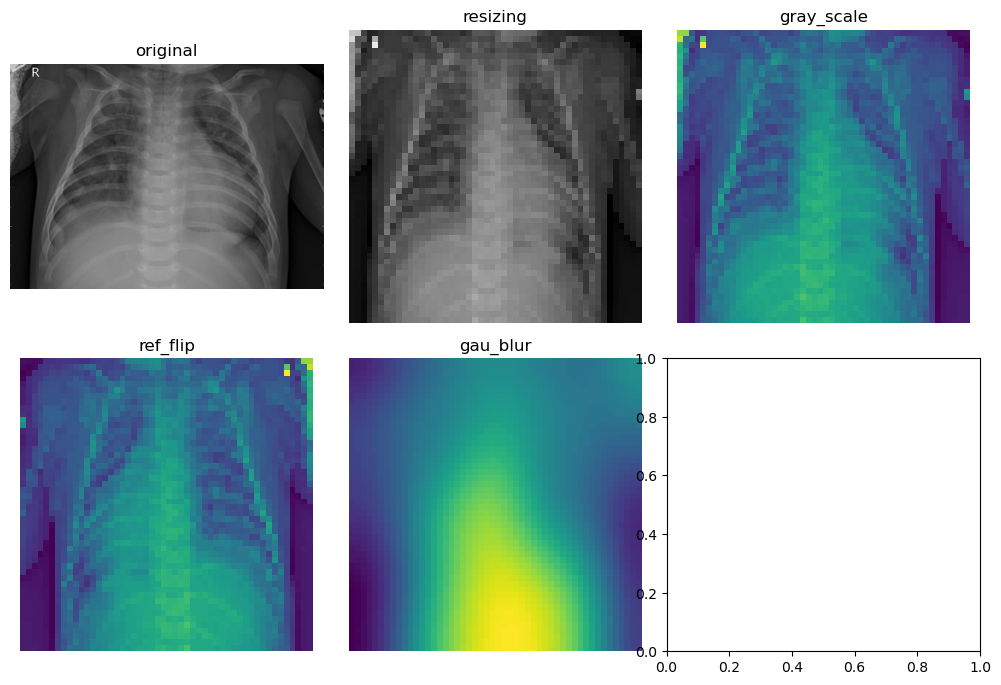

In [21]:
img_aug = [original, resizing, gray_scale, ref_flip, gau_blur, hist_eq, rotation, channel_con, color_con]
sample_img = cv2.imread(sample_path)
plt.figure(figsize=(10,10))
for aug in img_aug:
    ax = plt.subplot(3,3,img_aug.index(aug)+1)
    sample_img = aug(sample_img)
    plt.title(aug.__name__)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.tight_layout()   




Obviously we cannot perform all processing steps to the same image all together, it is only rational for us to find the most optimal way to prepare the image.

In [22]:
# pipeline implementation
def prepare(path, pipeline) : 
    img = cv2.imread(str(path))
    
    for transform in pipeline : 
        img = transform(img)
        
    return img

pipeline_1 = [original, resizing, gray_scale, ref_flip, gau_blur]

In [23]:
df_train['images'] = df_train['images'].apply(prepare,pipeline=pipeline_1)

In [24]:
df_train.head()

,images,label
0,"[[106, 106, 105, 104, 103, 101, 99, 97, 95, 93...",NORMAL
1,"[[56, 56, 57, 58, 60, 62, 63, 64, 66, 67, 68, ...",NORMAL
2,"[[58, 59, 62, 67, 72, 77, 83, 89, 95, 100, 106...",NORMAL
3,"[[44, 46, 50, 56, 64, 74, 84, 96, 107, 119, 13...",NORMAL
4,"[[54, 55, 57, 59, 63, 66, 69, 73, 76, 79, 81, ...",NORMAL


In [25]:
for i in range(len(df_train)):
    df_train['images'][i] = df_train['images'][i].astype(np.float32)/255
    
df_train['label'] = df_train['label'].astype(str)
df_train['label'] = df_train['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [26]:
df_train.sample(20)

,images,label
5157,"[[0.3529412, 0.35686275, 0.36078432, 0.3725490...",1
2302,"[[0.21176471, 0.21960784, 0.23529412, 0.258823...",1
969,"[[0.44313726, 0.44313726, 0.4392157, 0.4352941...",0
2617,"[[0.21176471, 0.21176471, 0.21176471, 0.211764...",1
3430,"[[0.2784314, 0.2784314, 0.28235295, 0.28627452...",1
1118,"[[0.44705883, 0.4509804, 0.45882353, 0.4666666...",0
4624,"[[0.23529412, 0.23921569, 0.24313726, 0.254901...",1
1805,"[[0.16470589, 0.16862746, 0.16862746, 0.172549...",1
1568,"[[0.21568628, 0.21568628, 0.21960784, 0.219607...",1
4361,"[[0.32156864, 0.32941177, 0.34509805, 0.364705...",1


In [31]:
data_train = np.array([df_train['images'][i] for i in range(len(df_train))])
data_train

array([[[0.41568628, 0.41568628, 0.4117647 , ..., 0.29803923,
         0.28627452, 0.28235295],
        [0.41568628, 0.41568628, 0.4117647 , ..., 0.29803923,
         0.28627452, 0.2784314 ],
        [0.41568628, 0.41568628, 0.4117647 , ..., 0.29803923,
         0.28627452, 0.2784314 ],
        ...,
        [0.20392157, 0.21176471, 0.22745098, ..., 0.2509804 ,
         0.23137255, 0.21960784],
        [0.20392157, 0.21176471, 0.22745098, ..., 0.2509804 ,
         0.23137255, 0.21960784],
        [0.20392157, 0.21176471, 0.22745098, ..., 0.2509804 ,
         0.23137255, 0.21960784]],

       [[0.21960784, 0.21960784, 0.22352941, ..., 0.25490198,
         0.24705882, 0.24313726],
        [0.21568628, 0.21960784, 0.22352941, ..., 0.2509804 ,
         0.24313726, 0.23921569],
        [0.21568628, 0.21568628, 0.21960784, ..., 0.24705882,
         0.23921569, 0.23529412],
        ...,
        [0.19215687, 0.2       , 0.21176471, ..., 0.22352941,
         0.20392157, 0.19215687],
        [0.1

## Stage 3: Model Definition and Training

### Sequential Setup

In [ ]:
model = Sequential()
model.add(Conv2D(16,(5,5),padding='valid',input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.4))
model.add(Conv2D(32,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.6))
model.add(Conv2D(64,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

### General Macine Learning Classifiers

##### SVM

##### KNN

##### Random Forest/ Decision Tree

### Deep Learning Models

##### CNN

##### yolo

##### vgg16

##### ResNet50

##### EfficientNet

## Stage 4: Model performance and evaluation

## Stage 5: Model Deployment